Importing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from datetime import timedelta


# **Preliminaries**

First we import the file '[owid-covid-data.csv](https://github.com/owid/covid-19-data/tree/master/public/data)'.

The COVID-19 dataset is a collection of the COVID-19 data maintained by *'Our World in Data'*. It is updated daily and includes data on confirmed cases, deaths, and testing, as well as other variables of potential interest.

In [2]:
covid = pd.read_csv('owid-covid-data (1).csv', 
                   index_col='iso_code',  parse_dates = ['date'])

# Converting timestamp to date:
covid.date = covid.date.dt.date
# covid.date.iloc[0]            # For testing

print("The dataset has {} records and {} columns.".format(covid.shape[0], covid.shape[1]))
covid.head()

The dataset has 34663 records and 35 columns.


,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
iso_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ABW,North America,Aruba,2020-03-13,2.0,2.0,0.0,0.0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
ABW,North America,Aruba,2020-03-20,4.0,2.0,0.0,0.0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.33,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
ABW,North America,Aruba,2020-03-24,12.0,8.0,0.0,0.0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
ABW,North America,Aruba,2020-03-25,17.0,5.0,0.0,0.0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
ABW,North America,Aruba,2020-03-26,19.0,2.0,0.0,0.0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


 The full description and source for each variable in the dataset is in the [CodeBook](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv).

In [3]:
covid.loc['ISR']

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
iso_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ISR,Asia,Israel,2019-12-31,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8655541.0,402.606,30.6,11.733,7.359,33132.32,0.5,93.32,6.74,15.4,35.4,NaN,2.99,82.97
ISR,Asia,Israel,2020-01-01,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8655541.0,402.606,30.6,11.733,7.359,33132.32,0.5,93.32,6.74,15.4,35.4,NaN,2.99,82.97
ISR,Asia,Israel,2020-01-02,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8655541.0,402.606,30.6,11.733,7.359,33132.32,0.5,93.32,6.74,15.4,35.4,NaN,2.99,82.97
ISR,Asia,Israel,2020-01-03,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8655541.0,402.606,30.6,11.733,7.359,33132.32,0.5,93.32,6.74,15.4,35.4,NaN,2.99,82.97
ISR,Asia,Israel,2020-01-04,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8655541.0,402.606,30.6,11.733,7.359,33132.32,0.5,93.32,6.74,15.4,35.4,NaN,2.99,82.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ISR,Asia,Israel,2020-07-31,70379.0,1823.0,503.0,12.0,8131.092,210.617,58.113,1.386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8655541.0,402.606,30.6,11.733,7.359,33132.32,0.5,93.32,6.74,15.4,35.4,NaN,2.99,82.97
ISR,Asia,Israel,2020-08-01,70970.0,591.0,512.0,9.0,8199.372,68.280,59.153,1.040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8655541.0,402.606,30.6,11.733,7.359,33132.32,0.5,93.32,6.74,15.4,35.4,NaN,2.99,82.97
ISR,Asia,Israel,2020-08-02,72283.0,1313.0,527.0,15.0,8351.067,151.695,60.886,1.733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8655541.0,402.606,30.6,11.733,7.359,33132.32,0.5,93.32,6.74,15.4,35.4,NaN,2.99,82.97


# **Data Inspection & Cleaning**

**Value counts**

In [4]:
covid.dtypes.value_counts()

float64    31
object      4
dtype: int64

**Missing values**

In [5]:
covid.reset_index().isnull().sum().sort_values()

location                               0
date                                   0
iso_code                              64
population                            64
continent                            282
total_cases                          341
new_cases                            341
total_deaths                         341
new_deaths                           341
total_cases_per_million              405
new_cases_per_million                405
total_deaths_per_million             405
new_deaths_per_million               405
life_expectancy                      484
population_density                  1573
diabetes_prevalence                 2415
cardiovasc_death_rate               3458
median_age                          3487
aged_70_older                       3648
gdp_per_capita                      3871
aged_65_older                       3941
hospital_beds_per_thousand          6314
stringency_index                    6510
female_smokers                      9934
male_smokers    

We find 293 missing values in 'continent'.



In [6]:
covid[covid['continent'].isnull()]

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
iso_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OWID_WRL,NaN,World,2019-12-31,27.0,27.0,0.0,0.0,0.003,0.003,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.794799e+09,58.045,30.9,8.696,5.355,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58
OWID_WRL,NaN,World,2020-01-01,27.0,0.0,0.0,0.0,0.003,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.794799e+09,58.045,30.9,8.696,5.355,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58
OWID_WRL,NaN,World,2020-01-02,27.0,0.0,0.0,0.0,0.003,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.794799e+09,58.045,30.9,8.696,5.355,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58
OWID_WRL,NaN,World,2020-01-03,44.0,17.0,0.0,0.0,0.006,0.002,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.794799e+09,58.045,30.9,8.696,5.355,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58
OWID_WRL,NaN,World,2020-01-04,44.0,0.0,0.0,0.0,0.006,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.794799e+09,58.045,30.9,8.696,5.355,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,NaN,International,2020-02-28,705.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,International,2020-02-29,705.0,0.0,6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,International,2020-03-01,705.0,0.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
covid[covid['continent'].isnull()].index.unique()

Index(['OWID_WRL', nan], dtype='object', name='iso_code')

We can see that there are two iso_code that have null values in continent column: 

1- 'OWID_WRL'- we will extract this data to separate dataframe.

In [8]:
# Extract to new data frame (called covid_world):
covid_world = covid.loc['OWID_WRL']
covid_world.head()

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
iso_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OWID_WRL,NaN,World,2019-12-31,27.0,27.0,0.0,0.0,0.003,0.003,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.794799e+09,58.045,30.9,8.696,5.355,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58
OWID_WRL,NaN,World,2020-01-01,27.0,0.0,0.0,0.0,0.003,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.794799e+09,58.045,30.9,8.696,5.355,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58
OWID_WRL,NaN,World,2020-01-02,27.0,0.0,0.0,0.0,0.003,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.794799e+09,58.045,30.9,8.696,5.355,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58
OWID_WRL,NaN,World,2020-01-03,44.0,17.0,0.0,0.0,0.006,0.002,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.794799e+09,58.045,30.9,8.696,5.355,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58
OWID_WRL,NaN,World,2020-01-04,44.0,0.0,0.0,0.0,0.006,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.794799e+09,58.045,30.9,8.696,5.355,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58


2- 'nan'- we will remove this data 


In [9]:
# Remove from covid data set:
covid=covid[~covid.continent.isnull()]
# Confirm the relevant data removed: 
# covid.info()

Moreover, we can see that most of the missing values are of tests variables.

We wanted to check the distribution of these missing values over continents, thus we created a bar plot of the total new tests per continent:

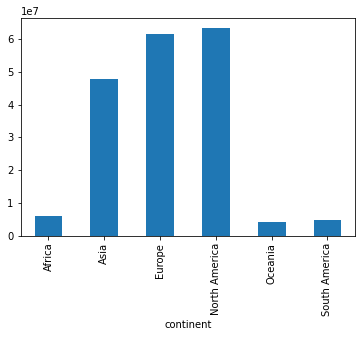

In [10]:
covid.groupby('continent')['new_tests'].sum().plot.bar()

**Note:**
Each continent has different number of countries...

**Duplicated values**

We checked for duplicated data, which we defined by country and date:

In [11]:
covid.select_dtypes(include=[object])
covid.reset_index().duplicated(subset=['iso_code', 'date']).value_counts()

False    34381
dtype: int64

# **Questions**

Some overview questions:

How many countries are represented in the data?

In [12]:
covid.index.nunique()

210

What is the timeline of the data set?

In [13]:
max_date= covid.date.max()
min_date= covid.date.min()
print('The data set timeline is from {} to {}'.format(min_date, max_date))

The data set timeline is from 2019-12-31 to 2020-08-04


How many total confirmed cases?

In [14]:
covid.new_cases.sum()


18262846.0

How many died worldwide?

In [15]:
covid.new_deaths.sum()

693719.0

# **TOP 5 COUNTRIES**

First, we will look at the top-5 countries according to their *population size* (i.e., the top-5 largest countries)

In [16]:
covid_top5= covid.groupby(covid.index).mean().sort_values(by='population', ascending=False) # Ascending order of the data set by population
covid_top5= covid_top5.iloc[0:5] # Take the largest countries

# Present who are the top-5 countries:
list_names= [country for country in covid.loc[covid_top5.index]["location"].unique()]
print('The top-5 countries in terms of population size (in descending order) are: ')
for name in list_names:
  print('{}'.format(name)) 

covid_top5 = covid.loc[covid_top5.index] # Take from 'covid' data set the whole data.
# covid_top5

The top-5 countries in terms of population size (in descending order) are: 
China
India
United States
Indonesia
Pakistan


**New cases timeline**

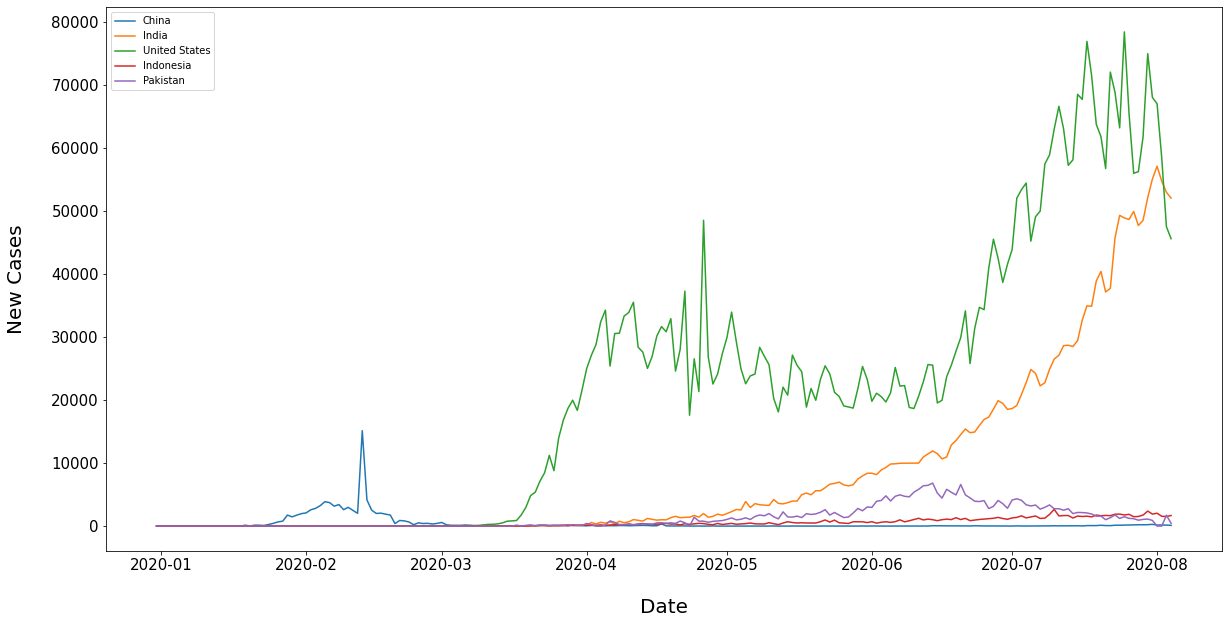

In [17]:
fig=plt.figure(figsize=(20,10))
ax=fig.gca()
for name in covid_top5.index.unique():
  covid_top5.loc[name].plot(x='date', y='new_cases', ax=ax)
ax.legend(covid_top5.location.unique())
ax.set_xlabel('Date', fontsize=20, labelpad=25)
ax.tick_params(axis='x', labelsize=15)
ax.set_ylabel(r"New Cases", fontsize=20, labelpad=25)
ax.tick_params(axis='y', labelsize=15)
plt.show()

**Tests Number**

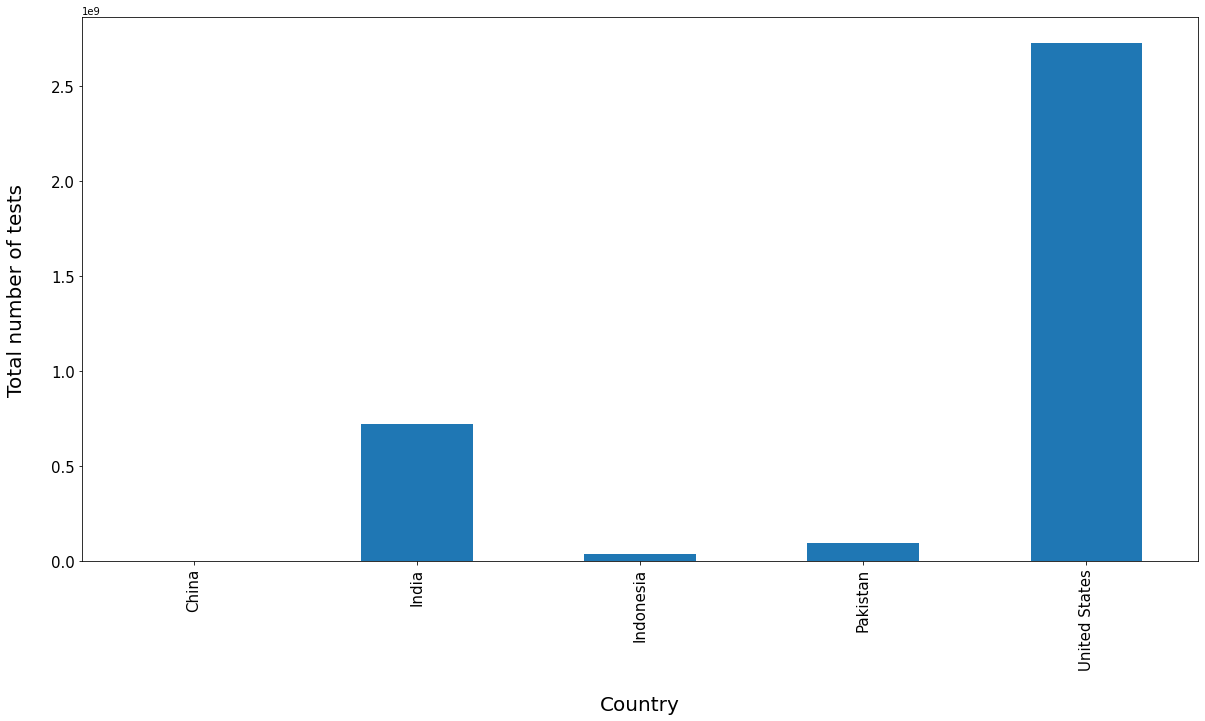

In [18]:
fig=plt.figure(figsize=(20,10))
ax=fig.gca()
covid_top5.groupby('location')['total_tests'].sum().plot.bar(ax=ax)
ax.set_xlabel('Country', fontsize=20, labelpad=25)
ax.tick_params(axis='x', labelsize=15)
ax.set_ylabel(r"Total number of tests", fontsize=20, labelpad=25)
ax.tick_params(axis='y', labelsize=15)

plt.show()

**Number of deaths**

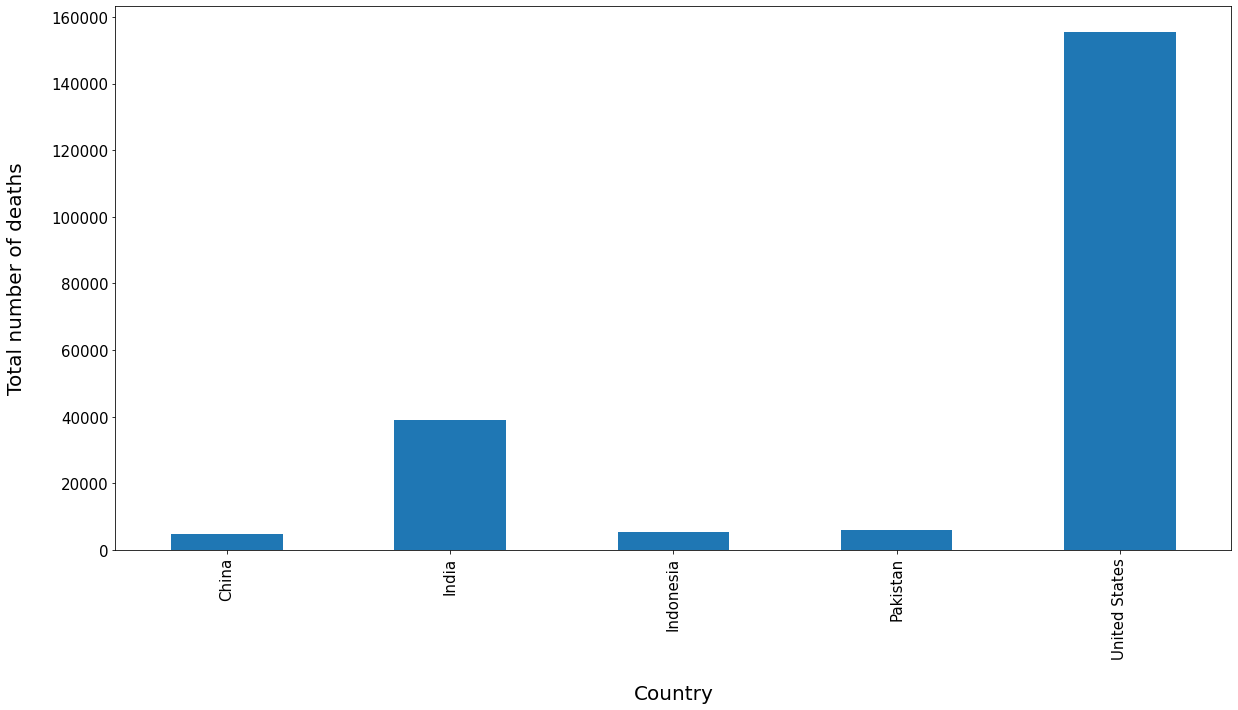

In [19]:
fig=plt.figure(figsize=(20,10))
ax=fig.gca()

covid_top5.groupby('location')['total_deaths'].max().plot.bar(ax=ax)
ax.set_xlabel('Country', fontsize=20, labelpad=25)
ax.tick_params(axis='x', labelsize=15)
ax.set_ylabel(r"Total number of deaths", fontsize=20, labelpad=25)
ax.tick_params(axis='y', labelsize=15)

plt.show()

**Share of the population that is 65 years and olders**

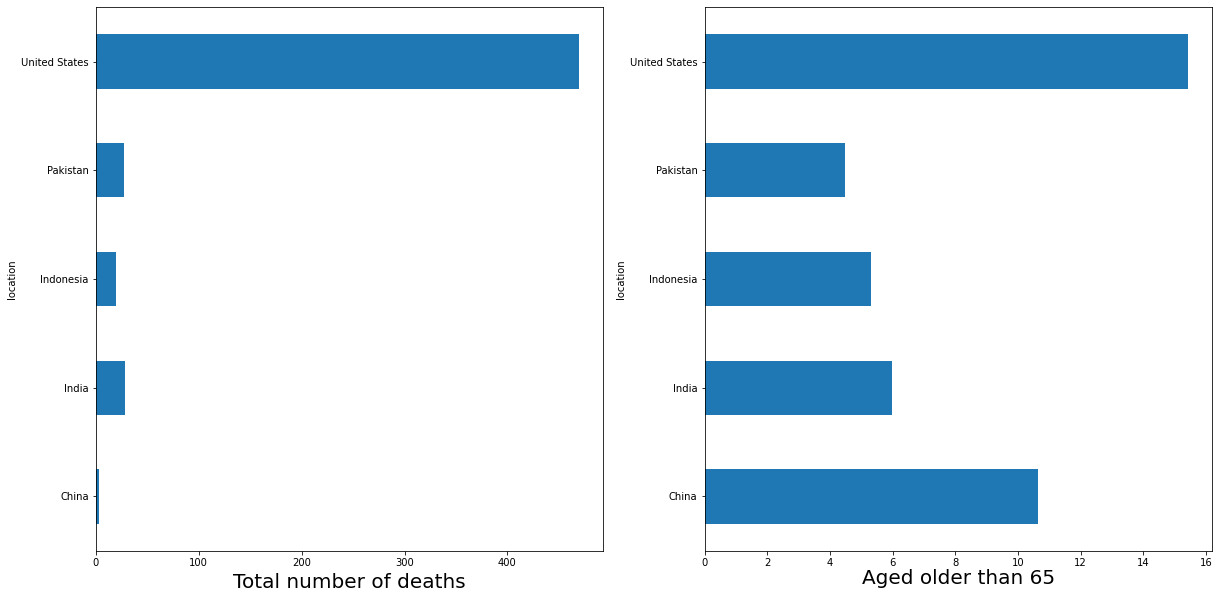

In [20]:
fig, axes=plt.subplots(1,2, figsize=(20,10))

covid_top5.groupby('location')['total_deaths_per_million'].max().plot.barh(ax=axes[0])
covid_top5.groupby('location')['aged_65_older'].mean().plot.barh(ax=axes[1])
# axes[0].set_xlabel('Country', fontsize=20, labelpad=20)
# axes[1].set_xlabel('Country', fontsize=20, labelpad=20)
axes[0].set_xlabel(r"Total number of deaths", fontsize=20, labelpad=5)
axes[1].set_xlabel(r"Aged older than 65", fontsize=20, labelpad=1)

plt.show()

# **Covid-19 in Israel**

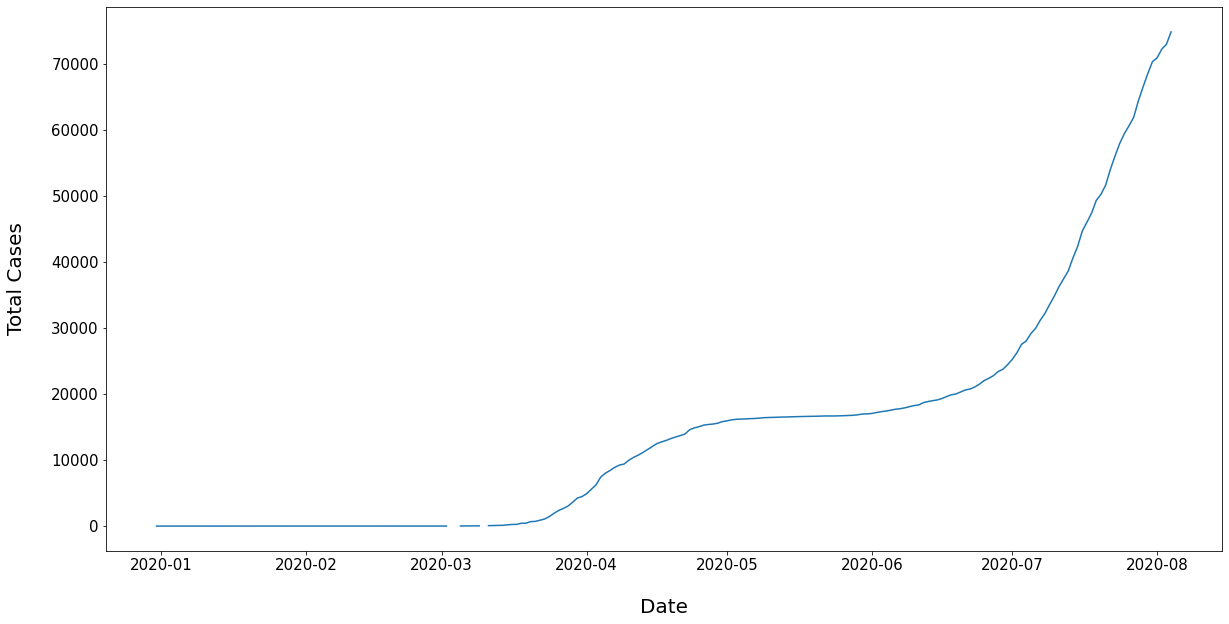

In [21]:
##Total cases in Israel##
fig=plt.figure(figsize=(20,10))
ax=fig.gca()
covid.loc['ISR'].plot(x='date', y='total_cases', ax=ax, color='#1f77b4')
ax.get_legend().remove()

ax.set_xlabel("Date", fontsize=20, labelpad=25)
ax.tick_params(axis='x', labelsize=15)
ax.set_ylabel(r"Total Cases", fontsize=20, labelpad=25)
ax.tick_params(axis='y', labelsize=15)
plt.show()

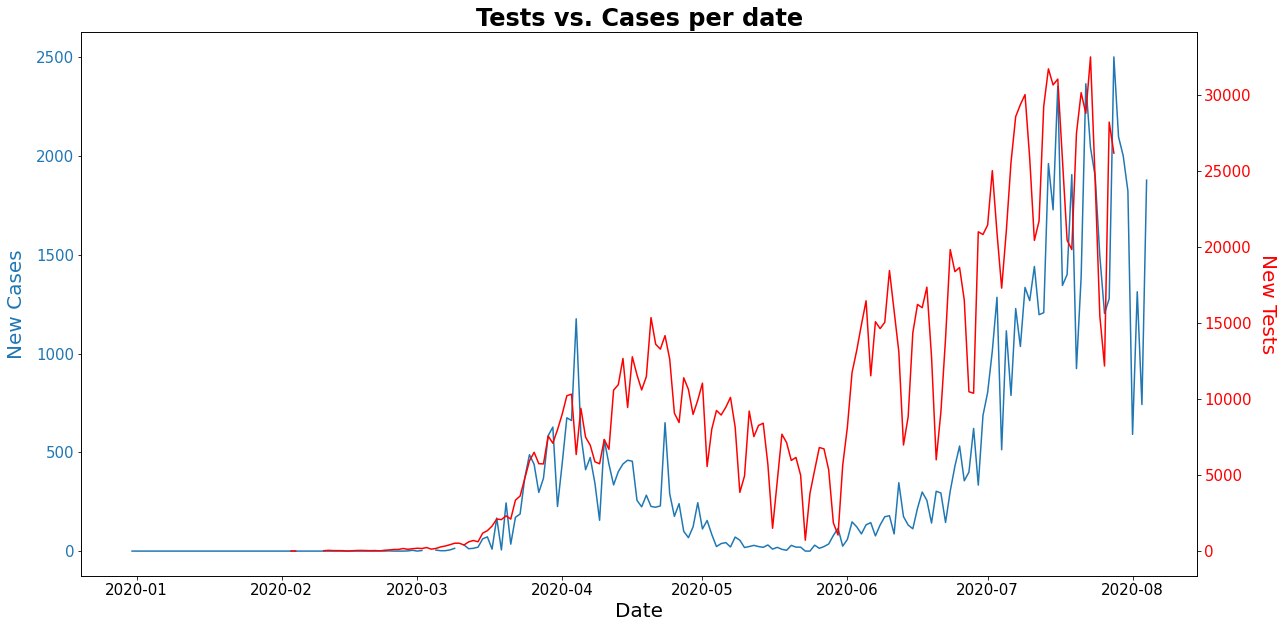

In [22]:
##New cases vs. new tests in Israel##
fig=plt.figure(figsize=(20,10))
ax1=fig.gca()
cases = covid.loc['ISR'].plot(x='date', y='new_cases', ax=ax1, color='#1f77b4')
ax1.get_legend().remove()
ax2=ax1.twinx()
tests = covid.loc['ISR'].plot(x='date', y='new_tests', ax=ax2, c='red')
ax2.get_legend().remove()

ax1.set_title('Tests vs. Cases per date', fontdict={'fontsize': 24, 'fontweight': 'bold'})

ax1.set_xlabel("Date", fontsize=20)
ax1.tick_params(axis='x', labelsize=15)
ax1.set_ylabel(r"New Cases", color='#1f77b4', fontsize=20, labelpad=10)
ax1.tick_params(axis='y', labelcolor='#1f77b4', labelsize=15)
ax2.set_ylabel(r"New Tests", c='red', fontsize=20, labelpad=25, rotation=-90)
ax2.tick_params(axis='y', labelcolor='red', labelsize=15)
plt.show()

We wanted to check the relation between the cases and the lockdown.

Due to delayed effect of the lockdown, we created also a column for shifted date (by 2 weeks) and compared it too.

First we will see the new cases vs. the stringency index:


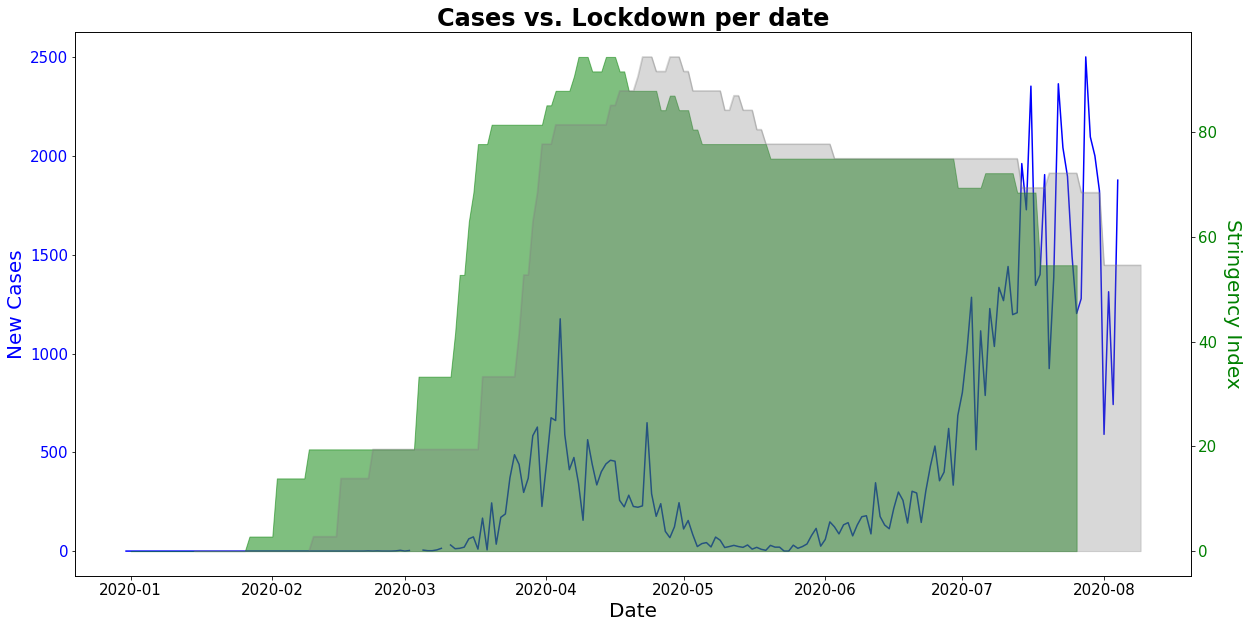

In [23]:
##Lockdown in Israel - cases##
fig=plt.figure(figsize=(20,10))
ax1=fig.gca()
cases = covid.loc['ISR'].plot(x='date', y='new_cases', ax=ax1, c='blue')
covid["2w_DATE"] = covid["date"] + timedelta(days=14)
ax1.get_legend().remove()
ax2=ax1.twinx()
lockdown = covid.loc['ISR'].plot(x='date', y='stringency_index', ax=ax2, c='green',  alpha=0)
lockdown2 = covid.loc['ISR'].plot(x='2w_DATE', y='stringency_index', ax=ax2, c='grey',  alpha=1.3)
ax2.get_legend().remove()

ax1.set_title('Cases vs. Lockdown per date', fontdict={'fontsize': 24, 'fontweight': 'bold'})

ax1.set_xlabel("Date", fontsize=20)
ax1.tick_params(axis='x', labelsize=15)
ax1.set_ylabel(r"New Cases", c='blue', fontsize=20)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=15)
ax2.set_ylabel(r"Stringency Index", c='green', fontsize=20, labelpad=25, rotation= -90)
ax2.tick_params(axis='y', labelcolor='green', labelsize=15)
ax2.fill_between(x=covid.loc['ISR']['date'], y1=covid.loc['ISR']['stringency_index'], color='green', alpha=0.5)
ax2.fill_between(x=covid.loc['ISR']['2w_DATE'], y1=covid.loc['ISR']['stringency_index'], color='grey', alpha=0.3)

plt.show()

Then we compared the lockdown to the positive rate:

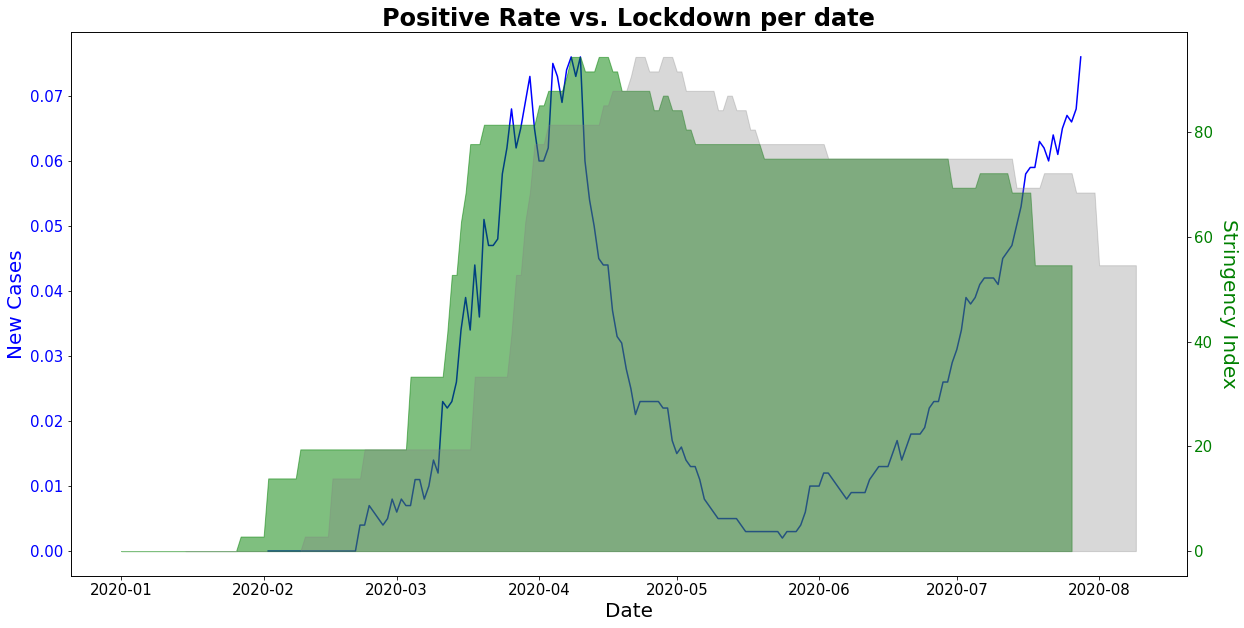

In [24]:
##Lockdown in Israel - positive rate##
fig=plt.figure(figsize=(20,10))
ax1=fig.gca()
cases = covid.loc['ISR'].plot(x='date', y='positive_rate', ax=ax1, c='blue')
covid["2w_DATE"] = covid["date"] + timedelta(days=14)
ax1.get_legend().remove()
ax2=ax1.twinx()
lockdown = covid.loc['ISR'].plot(x='date', y='stringency_index', ax=ax2, c='green',  alpha=0)
lockdown2 = covid.loc['ISR'].plot(x='2w_DATE', y='stringency_index', ax=ax2, c='grey',  alpha=0)
ax2.get_legend().remove()

ax1.set_title('Positive Rate vs. Lockdown per date', fontdict={'fontsize': 24, 'fontweight': 'bold'})

ax1.set_xlabel("Date", fontsize=20)
ax1.tick_params(axis='x', labelsize=15)
ax1.set_ylabel(r"New Cases", c='blue', fontsize=20)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=15)
ax2.set_ylabel(r"Stringency Index", c='green', fontsize=20, labelpad=25, rotation= -90)
ax2.tick_params(axis='y', labelcolor='green', labelsize=15)
ax2.fill_between(x=covid.loc['ISR']['date'], y1=covid.loc['ISR']['stringency_index'], color='green', alpha=0.5)
ax2.fill_between(x=covid.loc['ISR']['2w_DATE'], y1=covid.loc['ISR']['stringency_index'], color='grey', alpha=0.3)

plt.show()

# **Top-5 cases and Israel:**

After we saw some data from Israel, we aimed to compare it with another top-5 countries- according to the *total number of new cases*.

In [25]:
# Creating new data set of the top-5 countries and Israel:

covid_by_new_cases= covid.groupby(covid.index).sum().sort_values(by='new_cases', ascending=False) # Ascending order of the data set by new_cases_per_million
covid_by_new_cases= covid_by_new_cases.iloc[0:5] 
# Present who are the top-5 countries:
list_names= [country for country in covid.loc[covid_by_new_cases.index]["location"].unique()]
print('The top-5 countries in terms of total amount of cases (in descending order) are: ')
for name in list_names:
  print('{}'.format(name)) 
# Create a list of the indices names (including Israel):
ind_countries= covid_by_new_cases.index.to_list()+['ISR'] 
# Extract full data from covid data set:
covid_by_new_cases = covid[covid.index.isin(ind_countries)] 


The top-5 countries in terms of total amount of cases (in descending order) are: 
United States
Brazil
India
Russia
South Africa


**Total new cases**

Let's check the amount of total new cases:

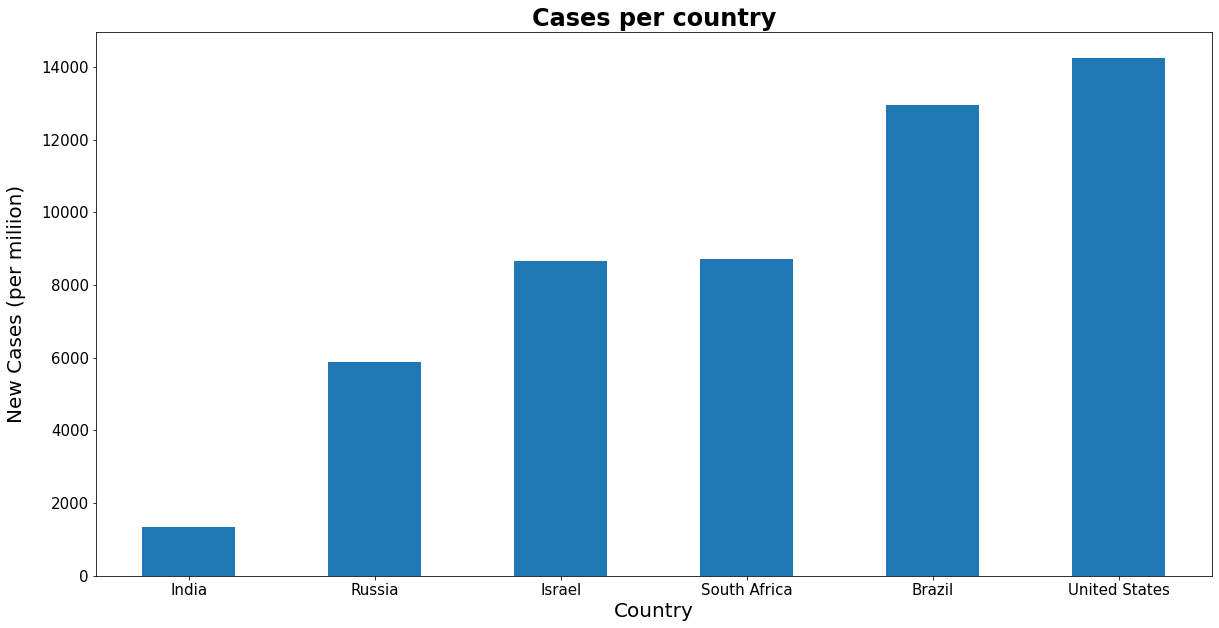

In [26]:
fig=plt.figure(figsize=(20,10))
ax=fig.gca()

covid_by_new_cases.groupby(covid_by_new_cases.location)['new_cases_per_million'].sum().sort_values().plot.bar(ax=ax)

ax.set_title('Cases per country', fontdict={'fontsize': 24, 'fontweight': 'bold'})

ax.set_xlabel("Country", fontsize=20)
ax.tick_params(axis='x', labelsize=15, rotation=0)
ax.set_ylabel(r"New Cases (per miliion)", fontsize=20,labelpad=15)
ax.tick_params(axis='y', labelsize=15)

plt.show()

And let's see the deaths ratio:

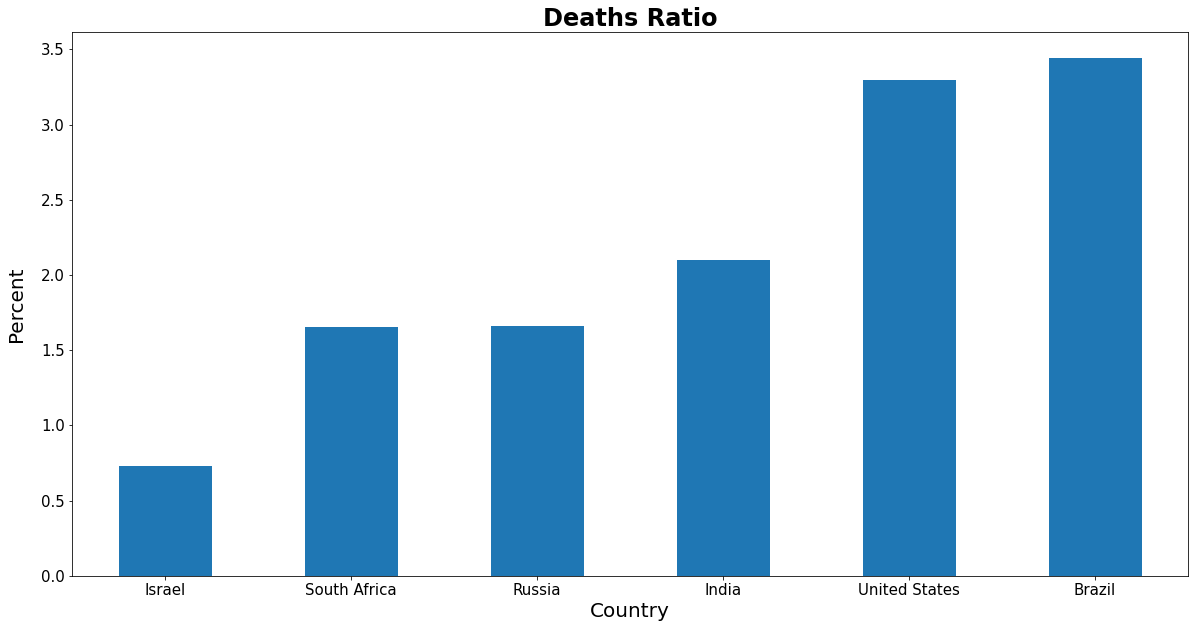

In [27]:
# setting the deaths percent (=total deaths/total cases)
deaths_percent = (covid_by_new_cases.groupby(covid_by_new_cases.location)['total_deaths'].max() / covid_by_new_cases.groupby(covid_by_new_cases.location)['total_cases'].max()) *100

fig=plt.figure(figsize=(20,10))
ax=fig.gca()
deaths_percent.sort_values().plot.bar(ax=ax)

ax.set_title('Deaths Ratio', fontdict={'fontsize': 24, 'fontweight': 'bold'})

ax.set_xlabel("Country", fontsize=20)
ax.tick_params(axis='x', labelsize=15, rotation=0)
ax.set_ylabel(r"Percent", fontsize=20,labelpad=15)
ax.tick_params(axis='y', labelsize=15)

plt.show()

**Population density**

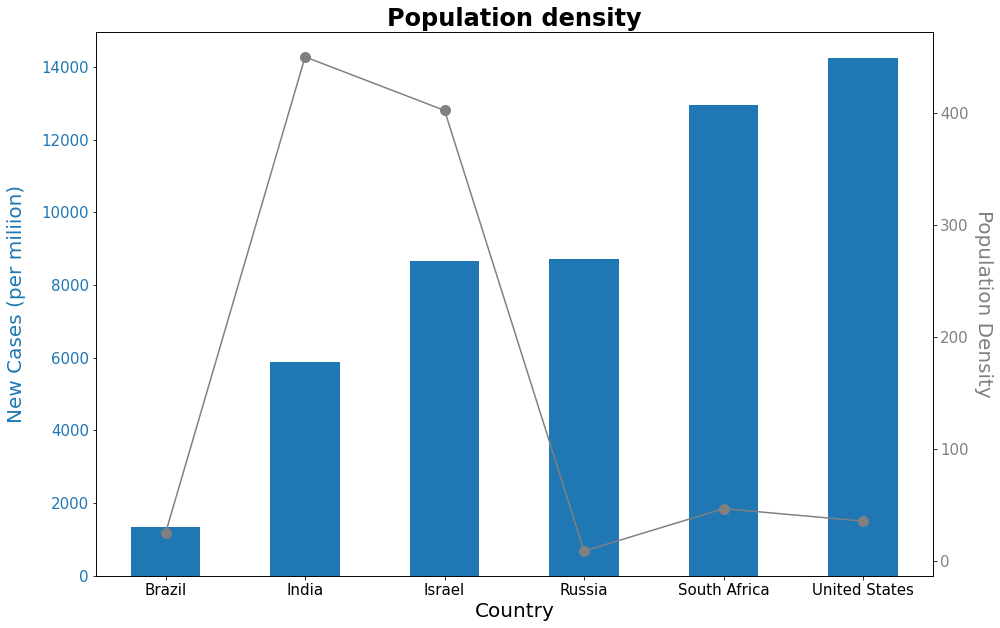

In [28]:
fig=plt.figure(figsize=(15,10))
ax1=fig.gca()
ax2=ax1.twinx()

covid_by_new_cases.groupby(covid_by_new_cases.location)['new_cases_per_million'].sum().sort_values().plot.bar(ax=ax1, color='#1f77b4')
covid_by_new_cases.groupby(covid_by_new_cases.location)['population_density'].mean().plot(ax=ax2, color='gray',  marker='o', markersize=10)

ax1.set_title('Population density', fontdict={'fontsize': 24, 'fontweight': 'bold'})

ax1.set_xlabel("Country", fontsize=20)
ax1.tick_params(axis='x', labelsize=15, rotation=0)

ax1.set_ylabel(r"New Cases (per miliion)", fontsize=20,labelpad=15, color='#1f77b4')
ax1.tick_params(axis='y', labelsize=15, labelcolor='#1f77b4')

ax2.set_ylabel(r"Population Density", c='gray', fontsize=20, labelpad=25, rotation= -90)
ax2.tick_params(axis='y', labelcolor='gray', labelsize=15)

plt.show()

**Lockdown**

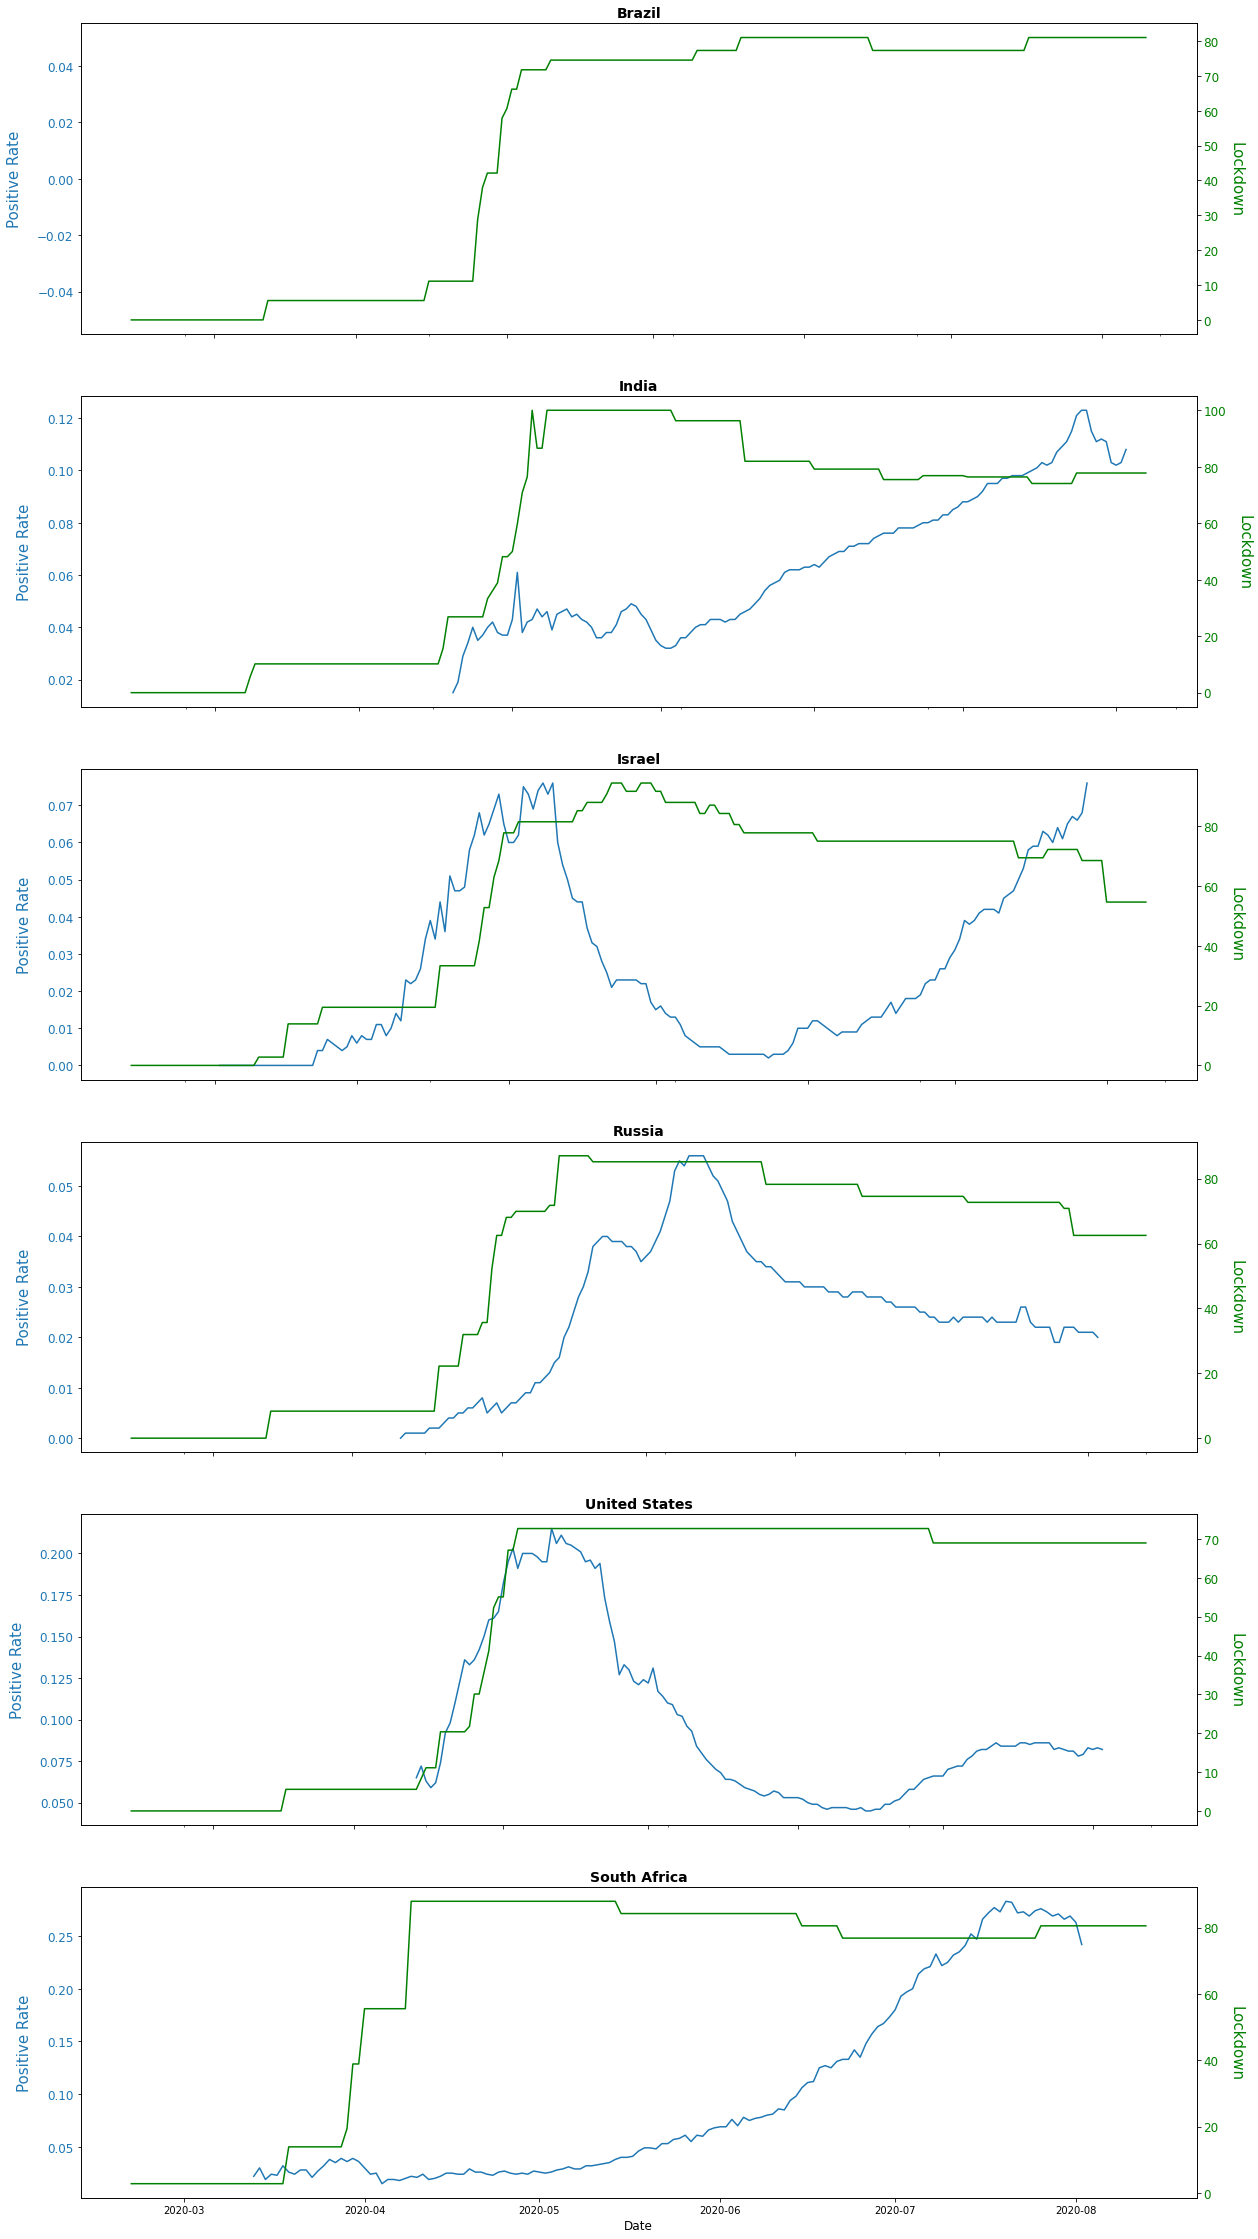

In [29]:
##vs. positive rate##

fig, axes=plt.subplots(6,1, figsize=(20,40))
countries=covid_by_new_cases.index.unique().to_list()
titles=list(covid_by_new_cases.location.unique())
twin= {}
ind=0

for i,ax in enumerate(axes):
  covid_by_new_cases.loc[countries[ind]].plot(x='date', y='positive_rate', ax=ax, color='#1f77b4')
  twin[i]=ax.twinx()
  covid_by_new_cases.loc[countries[ind]].plot(x='2w_DATE', y='stringency_index', ax=twin[i], c='green',  alpha=1)
  ax.set_title(titles[ind], fontdict={'fontsize': 14, 'fontweight': 'bold'})
  ind +=1
  # Define axes properties:
  ax.set_xlabel("Date", fontsize=12)
  ax.tick_params(axis='x', labelsize=10, rotation=0)

  ax.set_ylabel(r"Positive Rate", fontsize=15,labelpad=15, color='#1f77b4')
  ax.tick_params(axis='y', labelsize=12, labelcolor='#1f77b4')

  twin[i].set_ylabel(r"Lockdown", c='green', fontsize=15, labelpad=25, rotation= -90)
  twin[i].tick_params(axis='y', labelcolor='green', labelsize=12)
  # Remove legends:
  ax.get_legend().remove()
  twin[i].get_legend().remove()
  
plt.show()

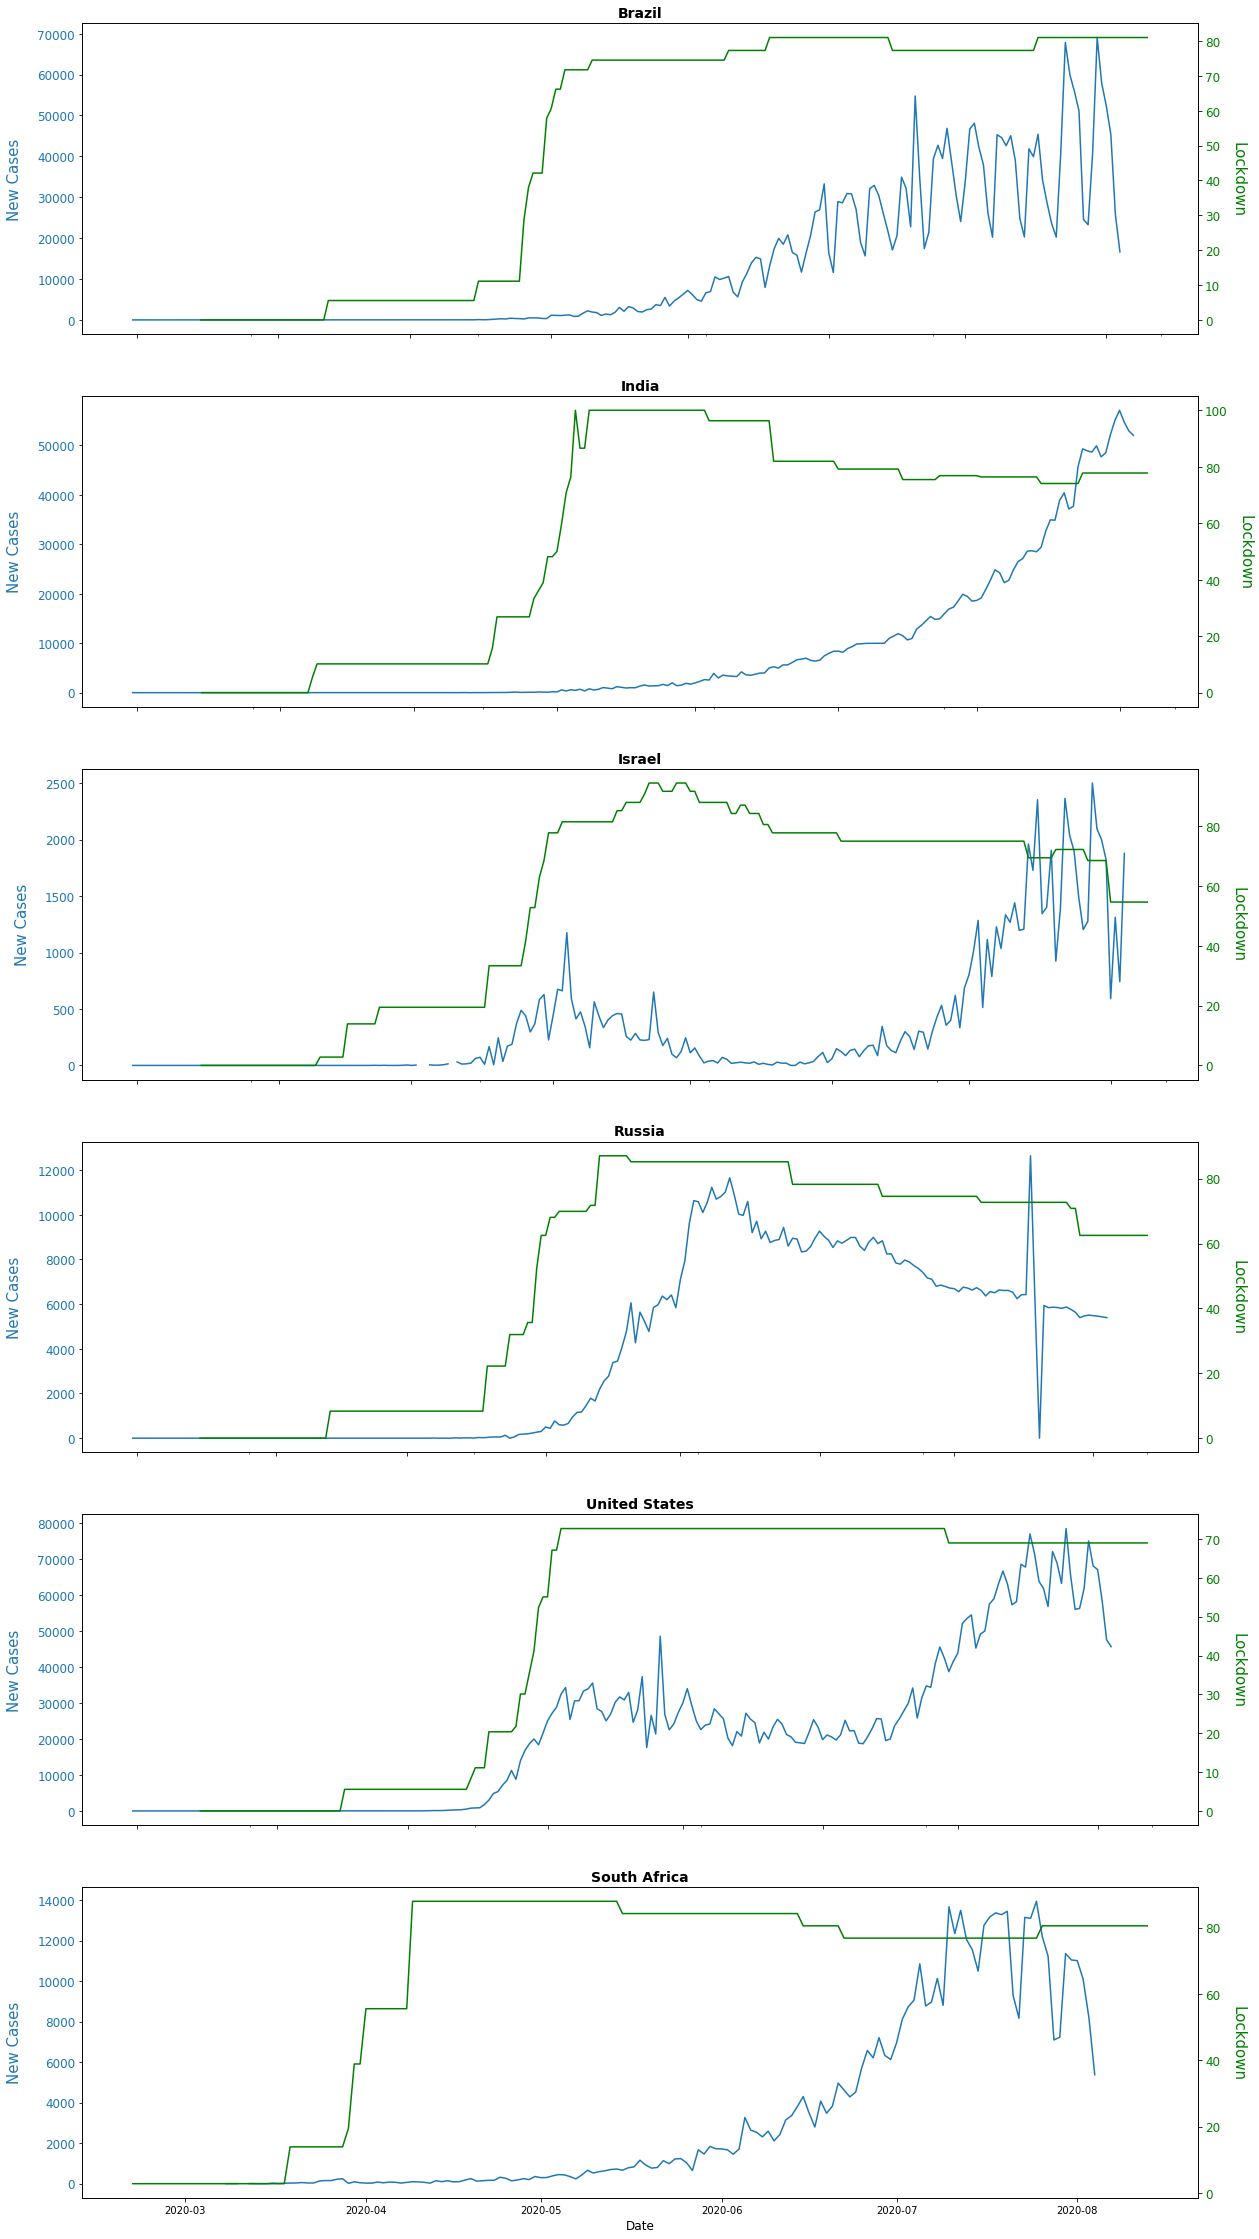

In [30]:
##vs. new cases##
fig, axes=plt.subplots(6,1, figsize=(20,40))
countries=covid_by_new_cases.index.unique().to_list()
titles=list(covid_by_new_cases.location.unique())
twin= {}
ind=0

for i,ax in enumerate(axes):
  covid_by_new_cases.loc[countries[ind]].plot(x='date', y='new_cases', ax=ax, color='#1f77b4')
  twin[i]=ax.twinx()
  covid_by_new_cases.loc[countries[ind]].plot(x='2w_DATE', y='stringency_index', ax=twin[i], c='green',  alpha=1)
  ax.set_title(titles[ind], fontdict={'fontsize': 14, 'fontweight': 'bold'})
  ind +=1
  # Define axes properties:
  ax.set_xlabel("Date", fontsize=12)
  ax.tick_params(axis='x', labelsize=10, rotation=0)

  ax.set_ylabel(r"New Cases", fontsize=15,labelpad=15, color='#1f77b4')
  ax.tick_params(axis='y', labelsize=12, labelcolor='#1f77b4')

  twin[i].set_ylabel(r"Lockdown", c='green', fontsize=15, labelpad=25, rotation= -90)
  twin[i].tick_params(axis='y', labelcolor='green', labelsize=12)
  # Remove legends:
  ax.get_legend().remove()
  twin[i].get_legend().remove()
  
plt.show()

**And New Zealand - for the reference...**

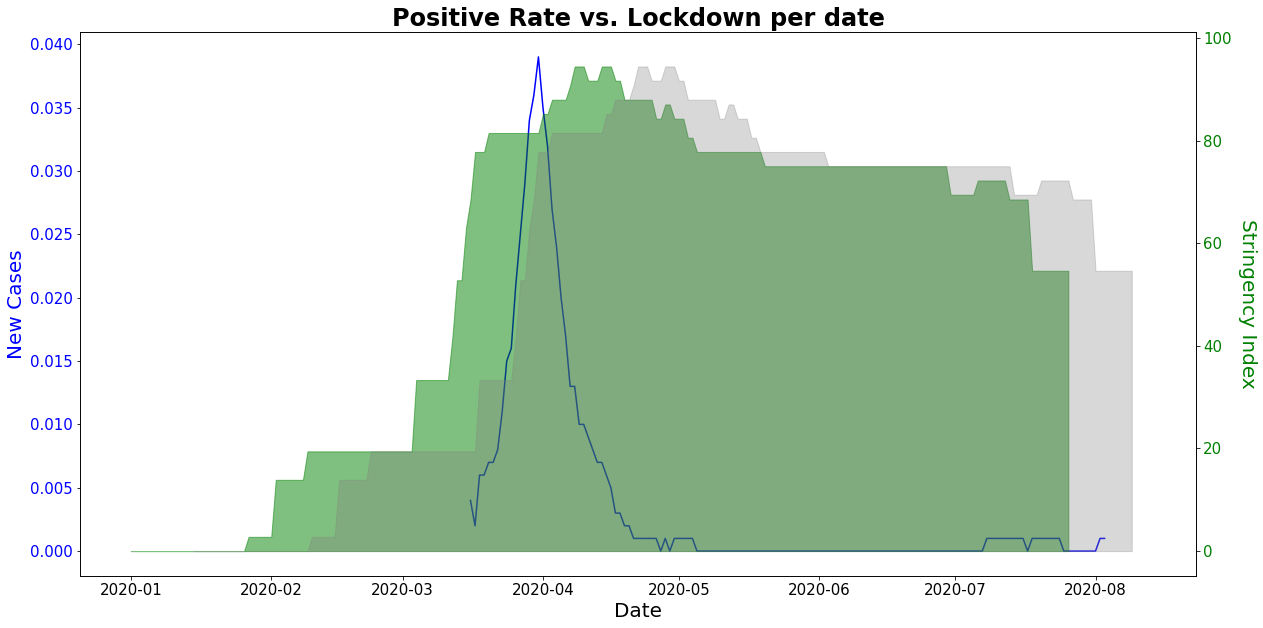

In [31]:
###New Zealand###
fig=plt.figure(figsize=(20,10))
ax1=fig.gca()
cases = covid.loc['NZL'].plot(x='date', y='positive_rate', ax=ax1, c='blue')
covid["2w_DATE"] = covid["date"] + timedelta(days=14)
ax1.get_legend().remove()
ax2=ax1.twinx()
lockdown = covid.loc['NZL'].plot(x='date', y='stringency_index', ax=ax2, c='green',  alpha=0)
lockdown2 = covid.loc['NZL'].plot(x='2w_DATE', y='stringency_index', ax=ax2, c='grey',  alpha=0)
ax2.get_legend().remove()

ax1.set_title('Positive Rate vs. Lockdown per date', fontdict={'fontsize': 24, 'fontweight': 'bold'})

ax1.set_xlabel("Date", fontsize=20)
ax1.tick_params(axis='x', labelsize=15)
ax1.set_ylabel(r"New Cases", c='blue', fontsize=20)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=15)
ax2.set_ylabel(r"Stringency Index", c='green', fontsize=20, labelpad=25, rotation= -90)
ax2.tick_params(axis='y', labelcolor='green', labelsize=15)
ax2.fill_between(x=covid.loc['ISR']['date'], y1=covid.loc['ISR']['stringency_index'], color='green', alpha=0.5)
ax2.fill_between(x=covid.loc['ISR']['2w_DATE'], y1=covid.loc['ISR']['stringency_index'], color='grey', alpha=0.3)

plt.show()

# **Israel vs. Sweden**

Population:

In [32]:
isr_swe = covid.loc[['ISR', 'SWE']]
isr_swe.groupby('location')['population'].mean()

location
Israel     8655541.0
Sweden    10099270.0
Name: population, dtype: float64

Cases, Deaths and Lockdown differences:

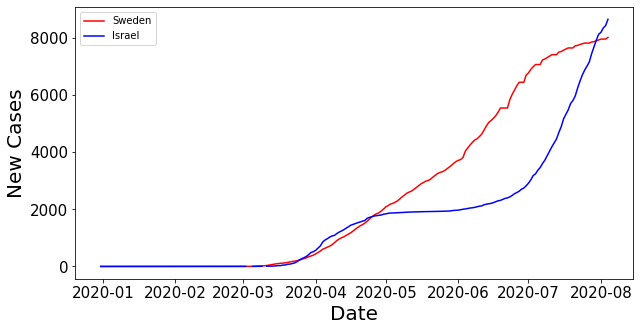

In [33]:
##total_cases_per_million##
fig=plt.figure(figsize=(10,5))
ax1=fig.gca()
covid.loc['SWE'].plot(x='date', y='total_cases_per_million', ax=ax1, c='red')
isr = covid.loc['ISR'].plot(x='date', y='total_cases_per_million', ax=ax1, c='blue')
ax1.set_xlabel("Date", fontsize=20)
ax1.tick_params(axis='x', labelsize=15)
ax1.set_ylabel(r"New Cases", fontsize=20)
ax1.tick_params(axis='y', labelsize=15)
ax1.legend(['Sweden', 'Israel'])


plt.show()

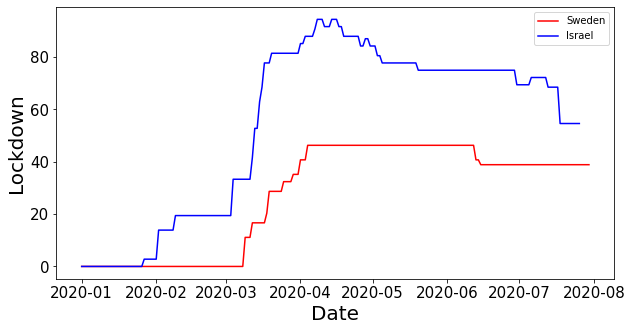

In [34]:
##stringency_index##
fig=plt.figure(figsize=(10,5))
ax1=fig.gca()
covid.loc['SWE'].plot(x='date', y='stringency_index', ax=ax1, c='red')
isr = covid.loc['ISR'].plot(x='date', y='stringency_index', ax=ax1, c='blue')
ax1.set_xlabel("Date", fontsize=20)
ax1.tick_params(axis='x', labelsize=15)
ax1.set_ylabel(r"Lockdown", fontsize=20)
ax1.tick_params(axis='y', labelsize=15)
ax1.legend(['Sweden', 'Israel'])


plt.show()

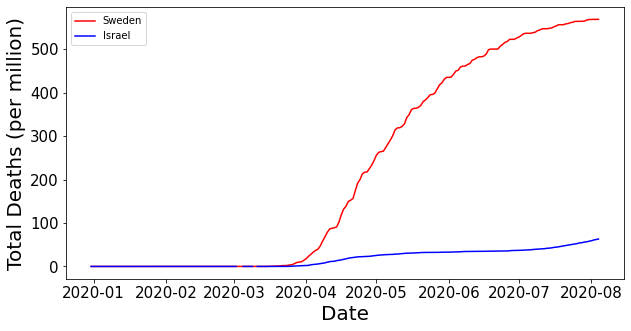

In [35]:
##total deaths##
fig=plt.figure(figsize=(10,5))
ax1=fig.gca()
covid.loc['SWE'].plot(x='date', y='total_deaths_per_million', ax=ax1, c='red')
isr = covid.loc['ISR'].plot(x='date', y='total_deaths_per_million', ax=ax1, c='blue')
ax1.set_xlabel("Date", fontsize=20)
ax1.tick_params(axis='x', labelsize=15)
ax1.set_ylabel(r"Total Deaths (per million)", fontsize=20)
ax1.tick_params(axis='y', labelsize=15)
ax1.legend(['Sweden', 'Israel'])


plt.show()

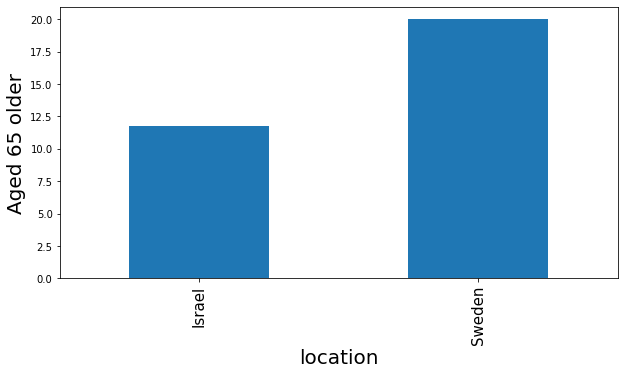

In [36]:
##aged 65##
fig=plt.figure(figsize=(10,5))
ax=fig.gca()
isr_swe = covid.loc[['ISR', 'SWE']]
isr_swe.groupby('location')['aged_65_older'].mean().plot.bar(ax=ax)
ax.set_xlabel(r"location", fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.set_ylabel(r"Aged 65 older", fontsize=20)
ax.tick_params(axis='y', labelsize=10)
plt.show()